In [1]:
import re
import json
import argparse
import os
import sys
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm
from nltk.stem import PorterStemmer
# from transformers import GPT2Tokenizer, GPT2Model
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login

from swisscom_ai.research_keyphrase.preprocessing.postagging import PosTaggingCoreNLP
from swisscom_ai.research_keyphrase.model.input_representation import InputTextObj
from swisscom_ai.research_keyphrase.model.extractor import extract_candidates


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='Noto_Sans_JP/NotoSansJP-Regular.otf')

c:\Users\user0\anaconda3\envs\LLM_ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
host = 'localhost'
port = 9000
pos_tagger = PosTaggingCoreNLP(host, port)

# load stopwords
stopwords = []
with open('UGIR_stopwords.txt', "r") as f:
    for line in f:
        if line:
            stopwords.append(line.replace('\n', ''))

stemmer = PorterStemmer()

def read_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            item = json.loads(line.strip())
            data.append(item)
    return data

In [3]:
def get_candidates(core_nlp, text):
    tagged = core_nlp.pos_tag_raw_text(text)
    text_obj = InputTextObj(tagged, 'en')
    candidates = extract_candidates(text_obj)
    return candidates

def get_phrase_indices(text_tokens, phrase, prefix):
    text_tokens = [t.replace(prefix, '') for t in text_tokens]

    phrase = phrase.replace(' ', '')

    matched_indices = []
    matched_index = []
    target = phrase
    for i in range(len(text_tokens)):
        cur_token = text_tokens[i]
        sub_len = min(len(cur_token), len(phrase))
        if cur_token[:sub_len].lower() == target[:sub_len]:
            matched_index.append(i)
            target = target[sub_len:]
            if len(target) == 0:
                matched_indices.append([matched_index[0], matched_index[-1] + 1])
                target = phrase
        else:
            matched_index = []
            target = phrase
            if cur_token[:sub_len].lower() == target[:sub_len]:
                matched_index.append(i)
                target = target[sub_len:]
                if len(target) == 0:
                    matched_indices.append([matched_index[0], matched_index[-1] + 1])
                    target = phrase

    return matched_indices

def remove_repeated_sub_word(candidates_pos_dict):
    for phrase in candidates_pos_dict.keys():
        split_phrase = re.split(r'\s+|-', phrase)
        split_phrase = list(filter(None, split_phrase))
        if len(split_phrase) > 1:
            for word in split_phrase:
                if word in candidates_pos_dict:
                    single_word_positions = candidates_pos_dict[word]
                    phrase_positions = candidates_pos_dict[phrase]
                    single_word_alone_positions = [pos for pos in single_word_positions if not any(
                        pos[0] >= phrase_pos[0] and pos[1] <= phrase_pos[1] for phrase_pos in phrase_positions)]
                    candidates_pos_dict[word] = single_word_alone_positions

    return candidates_pos_dict

def get_all_indices(candidates_pos_dict, window_end):
    all_indices = []
    for phrase in candidates_pos_dict.values():
        for element in phrase:
            start_index = element[0]
            end_index = element[1]
            if(start_index>window_end):
                all_indices.extend(range(start_index, end_index))
    all_indices = sorted(all_indices)
    all_indices = list(dict.fromkeys(all_indices))

    return all_indices

def aggregate_phrase_scores(index_list, tokens_scores):
    total_score = 0.0

    for p_index in index_list:
        part_sum = tokens_scores[p_index[0]:p_index[1]].sum()
        total_score += part_sum

    return total_score

def get_score_full(candidates, references, maxDepth=15):
    precision = []
    recall = []
    reference_set = set(references)
    referencelen = len(reference_set)
    true_positive = 0
    for i in range(maxDepth):
        if len(candidates) > i:
            kp_pred = candidates[i]
            if kp_pred in reference_set:
                true_positive += 1
            precision.append(true_positive / float(i + 1))
            recall.append(true_positive / float(referencelen))
        else:
            precision.append(true_positive / float(len(candidates)))
            recall.append(true_positive / float(referencelen))
    return precision, recall


def evaluate_document(candidates, ground_truth):
    results = {}
    precision_scores, recall_scores, f1_scores = {5: [], 10: [], 15: []}, \
                                                 {5: [], 10: [], 15: []}, \
                                                 {5: [], 10: [], 15: []}
    for candidate, gt in zip(candidates, ground_truth):
        p, r = get_score_full(candidate, gt)
        for i in [5, 10, 15]:
            precision = p[i - 1]
            recall = r[i - 1]
            if precision + recall > 0:
                f1_scores[i].append((2 * (precision * recall)) / (precision + recall))
            else:
                f1_scores[i].append(0)
            precision_scores[i].append(precision)
            recall_scores[i].append(recall)

    print("########################\nMetrics")
    for i in precision_scores:
        print("@{}".format(i))
        print("F1:{}".format(np.mean(f1_scores[i])))
        print("P:{}".format(np.mean(precision_scores[i])))
        print("R:{}".format(np.mean(recall_scores[i])))

        top_n_p = 'precision@' + str(i)
        top_n_r = 'recall@' + str(i)
        top_n_f1 = 'f1@' + str(i)
        results[top_n_p] = np.mean(precision_scores[i])
        results[top_n_r] = np.mean(recall_scores[i])
        results[top_n_f1] = np.mean(f1_scores[i])
    print("#########################")

    return results

def evaluate_dataset(predicted_top, dataset, score_type, dataset_name):
    experiment_results = []
    gt_keyphrase_list = []
    predicted_keyphrase_list = []

    for i in range(len(dataset)):
        predicted_keyphrase = predicted_top[i]
        predicted_keyphrase = [phrase.lower() for phrase in predicted_keyphrase]
        predicted_keyphrase_list.append(predicted_keyphrase)

        gt_keyphrase = [key.lower() for key in dataset[i]['keyphrases']]
        gt_keyphrase_list.append(gt_keyphrase)

    total_score = evaluate_document(predicted_keyphrase_list, gt_keyphrase_list)
    experiment_results.append(total_score)

    df = pd.DataFrame(experiment_results)

    path = f'experiment_results/{dataset_name}/'
    os.makedirs(path, exist_ok=True)
    df.to_csv(f'{path}score_type_{score_type}.csv', index=False)

    top3_f1_5 = df.nlargest(3, 'f1@5').reset_index(drop=True)
    top3_f1_10 = df.nlargest(3, 'f1@10').reset_index(drop=True)
    top3_f1_15 = df.nlargest(3, 'f1@15').reset_index(drop=True)

    return top3_f1_5, top3_f1_10, top3_f1_15

<img src="hugging_token.png" width=1000px></img>

In [4]:
# You need to request permission to use the LLAMA 3 model with your Huggingface account
login(token="YOUR_TOKEN_HERE")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\user0\.cache\huggingface\token
Login successful


In [5]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B", attn_implementation="eager", output_attentions=True)
prefix = 'Ġ'

c:\Users\user0\anaconda3\envs\LLM_ENV\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]
c:\Users\user0\anaconda3\envs\LLM_ENV\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


<h2>DATASET: INSPEC</h2>

In [48]:
dataset_name = "inspec"
dataset = read_jsonl("KEYWORD_DATA/{}.jsonl".format(dataset_name))

ATTENTIONSEEKER

In [49]:
model.to(device)
model.eval()

dataset_att_scores_overall = []

LH_MAP = torch.zeros(len(dataset),32,32)

for i_d,data in enumerate(tqdm(dataset)):
    with torch.no_grad():
        input_text = data["text"]

        tokenized_content = tokenizer(input_text, return_tensors='pt')
        outputs = model(**tokenized_content.to(device))
        content_tokens = tokenizer.convert_ids_to_tokens(tokenized_content['input_ids'].squeeze(0))

        all_attentions = outputs.attentions
        del outputs

        candidates = get_candidates(pos_tagger, input_text)
        candidates = [phrase for phrase in candidates if phrase.split(' ')[0] not in stopwords]
        candidates_indices = {}
        for phrase in candidates:
            matched_indices = get_phrase_indices(content_tokens, phrase, prefix)
            if len(matched_indices) == 0:
                continue
            candidates_indices[phrase] = matched_indices
        candidates_indices = remove_repeated_sub_word(candidates_indices)
        all_indices = get_all_indices(candidates_indices,0)

        ###############################################################
        #ATTENTION-SEEKER
        len_t_tokens = all_attentions[0].squeeze(0)[0].shape[0]
        all_indices_tensor = torch.arange(len_t_tokens)
        mask = torch.isin(all_indices_tensor, torch.tensor(all_indices)).to(device)
        mask_1 = mask*1.0
        # ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,mask_1)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
        att_scores = attentions
        att_scores[0] = 0
        # LHC-SEEKER
        f_att_scores = torch.zeros_like(att_scores)
        f_att_scores[mask] = att_scores[mask]
        # NEW ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,f_att_scores)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
                LH_MAP[i_d][layer][head] = lh_weight.mean(0)
        LH_MAP[i_d] = LH_MAP[i_d]/LH_MAP[i_d].mean()

100%|██████████| 500/500 [06:14<00:00,  1.34it/s]


In [9]:
x = LH_MAP
x_permuted = x.permute(0, 2, 1)
result_1= x_permuted.reshape(-1, 32)

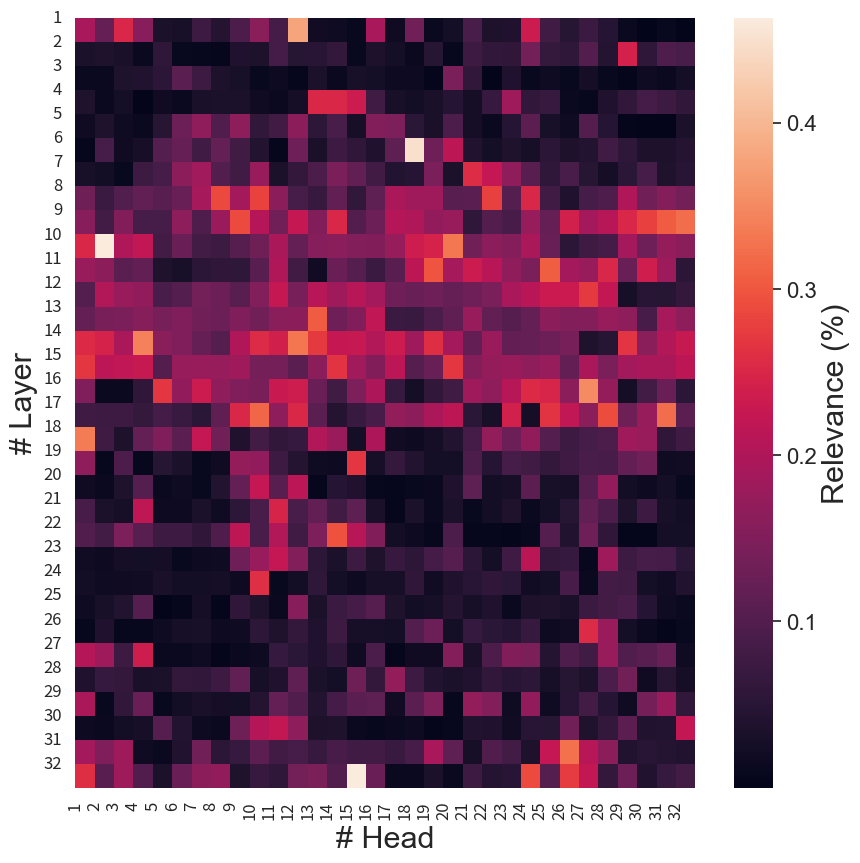

In [89]:
plt.close()
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(LH_MAP[0]/1024*100)
ax.collections[0].colorbar.set_label('Relevance (%)', fontsize=22)
ax.collections[0].colorbar.ax.tick_params(labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16) 
ax.set_xlabel("# Head", fontsize=22)
ax.set_ylabel("# Layer", fontsize=22)
ax.set_xticks(np.arange(32), labels=np.arange(32)+1,fontproperties=fprop)
ax.set_yticks(np.arange(32), labels=np.arange(32)+1,fontproperties=fprop)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the figure in high resolution (e.g., 300 dpi)
plt.savefig("All_relevance.png", dpi=300, bbox_inches='tight')
plt.show()

In [105]:
LH_MAP[0].sum(1)

tensor([27.7460, 17.8127,  9.6140, 20.1000, 21.2900, 25.0732, 29.9490, 46.4758,
        57.0907, 54.1919, 46.9733, 49.6930, 47.5513, 62.8066, 58.2910, 47.4622,
        47.8039, 36.3007, 22.9626, 18.0941, 19.2540, 27.4859, 23.8557, 13.5228,
        14.5846, 15.5827, 25.0885, 19.7761, 25.6739, 20.0042, 33.2304, 38.6591])

In [132]:
s_layer = 3 #3 y 14
with torch.no_grad():
    input_text = dataset[0]["text"]

    tokenized_content = tokenizer(input_text, return_tensors='pt')
    outputs = model(**tokenized_content.to(device))
    content_tokens = tokenizer.convert_ids_to_tokens(tokenized_content['input_ids'].squeeze(0))

    attentions = outputs.attentions
    del outputs

    candidates = get_candidates(pos_tagger, input_text)
    candidates = [phrase for phrase in candidates if phrase.split(' ')[0] not in stopwords]
    candidates_indices = {}
    for phrase in candidates:
        matched_indices = get_phrase_indices(content_tokens, phrase, prefix)
        if len(matched_indices) == 0:
            continue
        candidates_indices[phrase] = matched_indices
    candidates_indices = remove_repeated_sub_word(candidates_indices)

    ###############################################################
    # ATTENTION MEASSUREMENT
    attentions = attentions[s_layer]
    attentions = attentions.squeeze(0)
    att_scores = attentions.mean(0).sum(0)
    att_scores[0] = 0
    ###############################################################

    phrase_score_dict = {}
    for phrase in candidates_indices.keys():
        try:
            phrase_indices = candidates_indices[phrase]
            if len(phrase_indices) == 0:
                continue
        except KeyError:
            continue

        final_phrase_score = aggregate_phrase_scores(phrase_indices, att_scores)

        if len(phrase.split()) == 1:
            final_phrase_score = final_phrase_score / len(phrase_indices)
        phrase_score_dict[phrase] = final_phrase_score

sorted_scores_att_o_s = sorted(phrase_score_dict.items(), key=lambda item: item[1], reverse=True)

In [135]:
input_text

'Strategies for high throughput, templated zeolite synthesis. The design and redesign of high throughput experiments for zeolite synthesis are addressed. A model that relates materials function to the chemical composition of the zeolite and the structure directing agent is introduced. Using this model, several Monte Carlo-like design protocols are evaluated. Multi-round protocols are bound to be effective, and strategies that use a priori information about the structure-directing libraries are found to be the best'

In [134]:
pd.DataFrame({"tokens": content_tokens,"att": att_scores.cpu().numpy()}).to_csv("for_graph_1.csv")

<h2>DATASET: SEMEVAL 2017</h2>

In [12]:
dataset_name = "semeval2017"
dataset = read_jsonl("KEYWORD_DATA/{}.jsonl".format(dataset_name))

ATTENTIONSEEKER

In [13]:
model.to(device)
model.eval()

dataset_att_scores_overall = []

LH_MAP = torch.zeros(len(dataset),32,32)

for i_d,data in enumerate(tqdm(dataset)):
    with torch.no_grad():
        input_text = data["text"]

        tokenized_content = tokenizer(input_text, return_tensors='pt')
        outputs = model(**tokenized_content.to(device))
        content_tokens = tokenizer.convert_ids_to_tokens(tokenized_content['input_ids'].squeeze(0))

        all_attentions = outputs.attentions
        del outputs

        candidates = get_candidates(pos_tagger, input_text)
        candidates = [phrase for phrase in candidates if phrase.split(' ')[0] not in stopwords]
        candidates_indices = {}
        for phrase in candidates:
            matched_indices = get_phrase_indices(content_tokens, phrase, prefix)
            if len(matched_indices) == 0:
                continue
            candidates_indices[phrase] = matched_indices
        candidates_indices = remove_repeated_sub_word(candidates_indices)
        all_indices = get_all_indices(candidates_indices,0)

        ###############################################################
        #ATTENTION-SEEKER
        len_t_tokens = all_attentions[0].squeeze(0)[0].shape[0]
        all_indices_tensor = torch.arange(len_t_tokens)
        mask = torch.isin(all_indices_tensor, torch.tensor(all_indices)).to(device)
        mask_1 = mask*1.0
        # ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,mask_1)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
        att_scores = attentions
        att_scores[0] = 0
        # LHC-SEEKER
        f_att_scores = torch.zeros_like(att_scores)
        f_att_scores[mask] = att_scores[mask]
        # NEW ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,f_att_scores)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
                LH_MAP[i_d][layer][head] = lh_weight.mean(0)
        LH_MAP[i_d] = LH_MAP[i_d]/LH_MAP[i_d].mean()

100%|██████████| 493/493 [06:29<00:00,  1.27it/s]


In [14]:
x = LH_MAP
x_permuted = x.permute(0, 2, 1)
result_2 = x_permuted.reshape(-1, 32)

<h2>DATASET: SEMEVAL 2010</h2>

In [17]:
dataset_name = "semeval_test"
dataset = read_jsonl("KEYWORD_DATA/{}.json".format(dataset_name))

In [18]:
model.to(device)
model.eval()

dataset_att_scores_overall = []

LH_MAP = torch.zeros(len(dataset),32,32)

for i_d,data in enumerate(tqdm(dataset)):
    with torch.no_grad():
        input_text = data["title"] + ". " + data["abstract"] 

        tokenized_content = tokenizer(input_text, return_tensors='pt')
        outputs = model(**tokenized_content.to(device))
        content_tokens = tokenizer.convert_ids_to_tokens(tokenized_content['input_ids'].squeeze(0))

        all_attentions = outputs.attentions
        del outputs

        candidates = get_candidates(pos_tagger, input_text)
        candidates = [phrase for phrase in candidates if phrase.split(' ')[0] not in stopwords]
        candidates_indices = {}
        for phrase in candidates:
            matched_indices = get_phrase_indices(content_tokens, phrase, prefix)
            if len(matched_indices) == 0:
                continue
            candidates_indices[phrase] = matched_indices
        candidates_indices = remove_repeated_sub_word(candidates_indices)
        all_indices = get_all_indices(candidates_indices,0)

        ###############################################################
        #ATTENTION-SEEKER
        len_t_tokens = all_attentions[0].squeeze(0)[0].shape[0]
        all_indices_tensor = torch.arange(len_t_tokens)
        mask = torch.isin(all_indices_tensor, torch.tensor(all_indices)).to(device)
        mask_1 = mask*1.0
        # ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,mask_1)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
        att_scores = attentions
        att_scores[0] = 0
        # LHC-SEEKER
        f_att_scores = torch.zeros_like(att_scores)
        f_att_scores[mask] = att_scores[mask]
        # NEW ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,f_att_scores)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
                LH_MAP[i_d][layer][head] = lh_weight.mean(0)
        LH_MAP[i_d] = LH_MAP[i_d]/LH_MAP[i_d].mean()

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [19]:
x = LH_MAP
x_permuted = x.permute(0, 2, 1)
result_3 = x_permuted.reshape(-1, 32)

<h2>DATASET: KRAPIVIN</h2>

In [22]:
dataset_name = "krapivin_test"
dataset = read_jsonl("KEYWORD_DATA/{}.json".format(dataset_name))

In [23]:
model.to(device)
model.eval()

dataset_att_scores_overall = []

LH_MAP = torch.zeros(len(dataset),32,32)

for i_d,data in enumerate(tqdm(dataset)):
    with torch.no_grad():
        input_text = data["title"] + " " + data["abstract"] 

        tokenized_content = tokenizer(input_text, return_tensors='pt')
        outputs = model(**tokenized_content.to(device))
        content_tokens = tokenizer.convert_ids_to_tokens(tokenized_content['input_ids'].squeeze(0))

        all_attentions = outputs.attentions
        del outputs

        candidates = get_candidates(pos_tagger, input_text)
        candidates = [phrase for phrase in candidates if phrase.split(' ')[0] not in stopwords]
        candidates_indices = {}
        for phrase in candidates:
            matched_indices = get_phrase_indices(content_tokens, phrase, prefix)
            if len(matched_indices) == 0:
                continue
            candidates_indices[phrase] = matched_indices
        candidates_indices = remove_repeated_sub_word(candidates_indices)
        all_indices = get_all_indices(candidates_indices,0)

        ###############################################################
        #ATTENTION-SEEKER
        len_t_tokens = all_attentions[0].squeeze(0)[0].shape[0]
        all_indices_tensor = torch.arange(len_t_tokens)
        mask = torch.isin(all_indices_tensor, torch.tensor(all_indices)).to(device)
        mask_1 = mask*1.0
        # ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,mask_1)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
        att_scores = attentions
        att_scores[0] = 0
        # LHC-SEEKER
        f_att_scores = torch.zeros_like(att_scores)
        f_att_scores[mask] = att_scores[mask]
        # NEW ATTENTION MEASSUREMENT
        attentions = torch.zeros(len_t_tokens).to(device)
        for layer in range(len(all_attentions)):
            for head in range(32):
                crrn_att_map = all_attentions[layer].squeeze(0)[head].clone()
                crrn_att_map[~mask] = 0
                lh_weight = torch.matmul(crrn_att_map,f_att_scores)
                attentions += lh_weight.mean(0)*torch.matmul(lh_weight,crrn_att_map)
                LH_MAP[i_d][layer][head] = lh_weight.mean(0)
        LH_MAP[i_d] = LH_MAP[i_d]/LH_MAP[i_d].mean()

100%|██████████| 460/460 [05:48<00:00,  1.32it/s]


In [24]:
x = LH_MAP
x_permuted = x.permute(0, 2, 1)
result_4 = x_permuted.reshape(-1, 32)

In [30]:
result = torch.concat([result_1,result_2,result_3,result_4],axis=0)

In [31]:
means = result.mean(0)
_, ranks = means.sort()
ranks = ranks.argsort() 
palette = sns.color_palette("viridis", as_cmap=False, n_colors=len(means))
palette = [palette[int(rank)] for rank in ranks]  # Assign colors based on rank

c:\Users\user0\anaconda3\envs\LLM_ENV\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user0\anaconda3\envs\LLM_ENV\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user0\anaconda3\envs\LLM_ENV\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user0\anaconda3\envs\LLM_ENV\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed

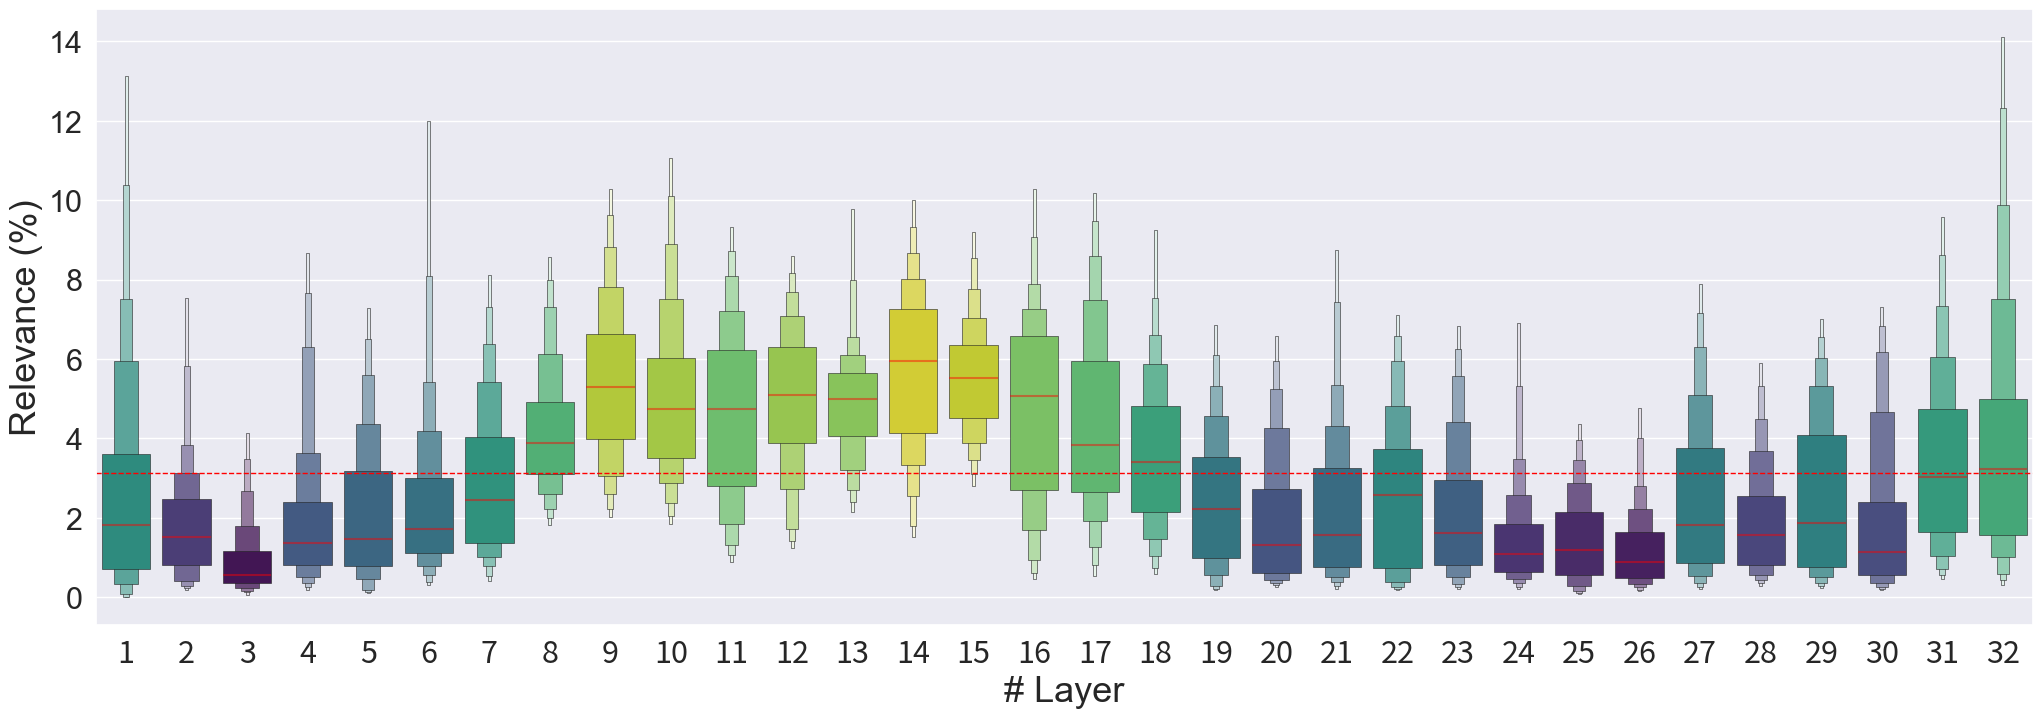

In [45]:
plt.close()
fig = plt.figure(figsize=(25,8))
ax = sns.boxenplot(data=result/1024*100*32, 
              k_depth="proportion", outlier_prop=0.05,
              linewidth=.4,
              line_kws=dict(linewidth=1.5, color="red"),
              flier_kws=dict(facecolor=".7", linewidth=.5),
              palette=palette,
              showfliers=False)
ax.axhline(y=3.125, color='red', linestyle='--', linewidth=1)
ax.set_xticks(np.arange(32), labels=np.arange(32)+1,fontproperties=fprop)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22) 
ax.set_xlabel("# Layer", fontsize=26)
ax.set_ylabel("Relevance (%)", fontsize=26)

# Save the figure in high resolution (e.g., 300 dpi)
plt.savefig("All_relevance.png", dpi=300, bbox_inches='tight')
plt.show()